In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from collections import *
import itertools
import json
import numpy as np
import scipy as sp
import pandas as pd
import csv


import xgboost as xgb


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set(font_scale=1.2)

from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

## Источники данных

In [3]:
COVID_19_plus_Russia = 'grwlf/COVID-19_plus_Russia'
CSSEGISandData = 'CSSEGISandData/COVID-19'
EXTERNAL_DATA_DIRNAME = '../external'

In [4]:
#! git clone https://github.com/{COVID_19_plus_Russia}.git {EXTERNAL_DATA_DIRNAME}/{COVID_19_plus_Russia}

In [5]:
#! git clone https://github.com/{CSSEGISandData}.git {EXTERNAL_DATA_DIRNAME}/{CSSEGISandData}

## Чтение данных

### Информация по странам и регионам

In [6]:
countries = pd.read_csv(os.path.join('data', 'countries.csv'))
countries.drop(['iso_alpha2','iso_numeric','official_name','name'], axis='columns',inplace=True)

In [7]:
countries.head()

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share
0,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050
1,ALB,Albania,105,1.6,27400,36.0,-14000.0,2877797,0.63,0.0004
2,DZA,Algeria,18,3.1,2381740,29.0,-10000.0,43851044,0.73,0.0056
3,AND,Andorra,164,NaN,470,NaN,NaN,77265,0.88,0.0000
4,AGO,Angola,26,5.6,1246700,17.0,6413.0,32866272,0.67,0.0042


In [8]:
regions = pd.read_csv(os.path.join('data', 'russia_regions.csv'))
regname2iso3 = dict(zip(regions.name_with_type, regions.iso_code))
regions = regions[["iso_code","csse_province_state","population","population_urban"]]
regions.population_urban = regions.population_urban/regions.population
regions.rename(columns={"iso_code": "iso_alpha3","csse_province_state":"ccse_name","population_urban":"urban_pop_rate"},
               inplace=True)

In [9]:
countries = pd.concat([countries, regions], sort=True)

In [10]:
countries.tail()

,ccse_name,density,fertility_rate,iso_alpha3,land_area,median_age,migrants,population,urban_pop_rate,world_share
80,Cheliabinsk oblast,NaN,NaN,RU-CHE,NaN,NaN,NaN,3466960,0.826372,NaN
81,Republic of Chuvashia,NaN,NaN,RU-CU,NaN,NaN,NaN,1217820,0.634003,NaN
82,Chukotskiy autonomous oblast,NaN,NaN,RU-CHU,NaN,NaN,NaN,50726,0.715077,NaN
83,Yamalo-Nenetskiy AO,NaN,NaN,RU-YAN,NaN,NaN,NaN,544008,0.839333,NaN
84,Yaroslavl oblast,NaN,NaN,RU-YAR,NaN,NaN,NaN,1253189,0.815866,NaN


In [11]:
country2iso3 = dict(zip(countries['ccse_name'], countries['iso_alpha3']))
iso32country = dict(zip(countries['iso_alpha3'], countries['ccse_name']))

### Исторические данные по странам из CSSEGISandData/COVID-19

In [12]:
data = pd.read_csv(
    os.path.join(
        EXTERNAL_DATA_DIRNAME, CSSEGISandData,
        'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_confirmed_global.csv')
)
data = data.groupby("Country/Region").sum()

data_lat_long = data.reset_index().iloc[:, :3]
data_lat_long.columns = ['country', 'lat', 'long']

data = data.iloc[:,4:].stack().reset_index()
data.columns = ['country', 'date', 'confirmed']

data_d = pd.read_csv(os.path.join(
    EXTERNAL_DATA_DIRNAME, CSSEGISandData, 
    'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_deaths_global.csv'))
data_d = data_d.groupby("Country/Region").sum()
data_d = data_d.iloc[:,4:].stack().reset_index()
data_d.columns = ['country', 'date', 'deaths']

data = data_lat_long.merge(data).merge(data_d)
data['date'] = pd.to_datetime(data['date'])

### Данные за последний по странам из CSSEGISandData/COVID-19 (web-data ветка)

In [13]:
CURRENT_DATE = '2020-04-25'

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

df_add = df[['Country_Region', 'Confirmed', 'Deaths']].copy()
df_add.columns = ['country', 'confirmed', 'deaths']

country2lat = dict(zip(data['country'], data['lat']))
country2long = dict(zip(data['country'], data['long']))
df_add['lat'] = df_add['country'].map(country2lat)
df_add['long'] = df_add['country'].map(country2long)

df_add['date'] = pd.to_datetime(CURRENT_DATE)
df_add[df_add['country'] == 'Russia']

,country,confirmed,deaths,lat,long,date
13,Russia,74588,681,60.0,90.0,2020-04-25


### Полные данные по странам

In [15]:
data = pd.concat([data, df_add[data.columns]])
data = data.sort_values(['country', 'date']).reset_index(drop=True)
data['iso3'] = data['country'].map(country2iso3)

data[data.iso3 == 'RUS'].tail()

,country,lat,long,date,confirmed,deaths,iso3
12922,Russia,60.0,90.0,2020-04-21,52763,456,RUS
12923,Russia,60.0,90.0,2020-04-22,57999,513,RUS
12924,Russia,60.0,90.0,2020-04-23,62773,555,RUS
12925,Russia,60.0,90.0,2020-04-24,68622,615,RUS
12926,Russia,60.0,90.0,2020-04-25,74588,681,RUS


### Данные по регионам России из grwlf/COVID-19_plus_Russia

In [16]:
data_Ru = pd.read_csv(os.path.join(EXTERNAL_DATA_DIRNAME, COVID_19_plus_Russia,
    'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_confirmed_RU.csv'
)).groupby("Province_State").sum()
data_Ru = data_Ru.iloc[:,15:].stack().reset_index()
data_Ru.columns = ["country","date","confirmed"]

data_deaths_Ru = pd.read_csv(os.path.join(EXTERNAL_DATA_DIRNAME, COVID_19_plus_Russia,
    'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_deaths_RU.csv'
)).groupby("Province_State").sum()
data_deaths_Ru = data_deaths_Ru.iloc[:,15:].stack().reset_index()
data_deaths_Ru.columns = ["country","date","deaths"]
data_Ru = data_Ru.merge(data_deaths_Ru, how = 'left', left_on=('country','date'), right_on=('country','date'))
data_Ru["recovered"] = 0

data_Ru.loc[data_Ru['country'] == 'Altay republic', 'country'] = 'Republic of Altay'

data_Ru['iso3'] = data_Ru['country'].map(country2iso3)
data_Ru['date'] = pd.to_datetime(data_Ru['date'])

In [17]:
data_Ru[data_Ru.iso3 == 'RU-MOW'].tail()

,country,date,confirmed,deaths,recovered,iso3
2692,Moscow,2020-04-20,26350,204,0,RU-MOW
2693,Moscow,2020-04-21,29433,233,0,RU-MOW
2694,Moscow,2020-04-22,31981,261,0,RU-MOW
2695,Moscow,2020-04-23,33940,288,0,RU-MOW
2696,Moscow,2020-04-24,36897,325,0,RU-MOW


In [18]:
print(data.date.min(), data_Ru.date.min())

2020-01-24 00:00:00 2020-01-29 00:00:00


#### Добавим недостающие 5 январских дней в данные по регионам

In [19]:
dates = list(data[data['country'] == 'Russia']['date'])
one_day = data_Ru[data_Ru['date'] == data_Ru.date.min()].reset_index(drop=True)
for dt in dates[:5]:
    one_day['confirmed'] = 0
    one_day['date'] = dt
    data_Ru = pd.concat([data_Ru, one_day])

In [20]:
data_Ru[data_Ru.iso3 == 'RU-MOW'].tail(7)

,country,date,confirmed,deaths,recovered,iso3
2695,Moscow,2020-04-23,33940,288,0,RU-MOW
2696,Moscow,2020-04-24,36897,325,0,RU-MOW
30,Moscow,2020-01-24,0,0,0,RU-MOW
30,Moscow,2020-01-25,0,0,0,RU-MOW
30,Moscow,2020-01-26,0,0,0,RU-MOW
30,Moscow,2020-01-27,0,0,0,RU-MOW
30,Moscow,2020-01-28,0,0,0,RU-MOW


### Данные по регионам России за сегодня

(сохраняем вручную в 'data/russia_today.txt' с сайта Роспотребнадзора https://www.rospotrebnadzor.ru/about/info/news/news_details.php?ELEMENT_ID=14316)

формат:
```
1. Москва - 3570
2. Московская область - 709
3. Нижегородская область - 129
4. Санкт-Петербург - 114
5. Архангельская область - 68
...
```

In [22]:
last_day_confirmed = dict(zip(
    data_Ru[data_Ru.date ==max(data_Ru.date)].iso3, 
    data_Ru[data_Ru.date == max(data_Ru.date)].confirmed
))

df_add_ru = []
with open(os.path.join('data', 'russia_today.txt'), encoding='utf-8') as fin:
    for line in fin:
        arr = line.strip().replace('г.', 'г').split('.')[1].strip().split(' - ')
        arr[0] = (
            arr[0]
            .replace('область', 'обл')
            .replace('Республика', 'Респ')
            .replace('Москва', 'г Москва')
            .replace('Санкт-Петербург', 'г Санкт-Петербург')
            .replace('Чеченская Респ', 'Респ Чеченская')
            .replace('Респ Саха (Якутия)', 'Респ Саха /Якутия/')
            .replace('Чувашская Респ', 'Чувашская Республика - Чувашия')
            .replace('Респ Северная Осетия', 'Респ Северная Осетия - Алания')
            .replace('Кабардино-Балкарская Респ', 'Респ Кабардино-Балкарская')
            .replace('Карачаево-Черкесская Респ', 'Респ Карачаево-Черкесская')
            .replace('Ханты-Мансийский АО', 'Ханты-Мансийский Автономный округ - Югра')
            .replace('Кемеровская обл', 'Кемеровская область - Кузбасс')
            .replace('Удмуртская Респ', 'Респ Удмуртская')
            .replace('Еврейская АО', 'Еврейская Аобл')
            .replace('гСевастополь', 'г Севастополь')
        )
        if arr[0] not in regname2iso3:
            print(arr)
        last_day_confirmed[regname2iso3[arr[0]]] += int(arr[1])
df_add_ru = pd.DataFrame(list(last_day_confirmed.items()), columns=['iso3', 'confirmed'])
df_add_ru['date'] = pd.to_datetime(CURRENT_DATE)

### Полные данные по регионам

In [23]:
data_Ru = pd.concat([data_Ru[['iso3', 'confirmed', 'date']], df_add_ru])
data_Ru['country'] = data_Ru['iso3'].map(iso32country)
data_Ru = data_Ru.sort_values(['country', 'date']).reset_index(drop=True)

In [24]:
data_Ru[data_Ru.iso3 == 'RU-MOW'].tail(5)

,iso3,confirmed,date,country
2785,RU-MOW,29433,2020-04-21,Moscow
2786,RU-MOW,31981,2020-04-22,Moscow
2787,RU-MOW,33940,2020-04-23,Moscow
2788,RU-MOW,36897,2020-04-24,Moscow
2789,RU-MOW,39509,2020-04-25,Moscow


### Полные данные на текущий день: страны + регионы

In [25]:
data = pd.concat([data, data_Ru], sort=True).reset_index(drop=True)

In [26]:
data[data.iso3.isin(['RUS', 'RU-MOW'])].sort_values(['date', 'iso3']).tail(6)

,confirmed,country,date,deaths,iso3,lat,long
19992,33940,Moscow,2020-04-23,NaN,RU-MOW,NaN,NaN
12924,62773,Russia,2020-04-23,555.0,RUS,60.0,90.0
19993,36897,Moscow,2020-04-24,NaN,RU-MOW,NaN,NaN
12925,68622,Russia,2020-04-24,615.0,RUS,60.0,90.0
19994,39509,Moscow,2020-04-25,NaN,RU-MOW,NaN,NaN
12926,74588,Russia,2020-04-25,681.0,RUS,60.0,90.0


## Подготавливаем датасет

### Объединеям все даты в исторических данных и даты для прогноза

In [27]:
dates = list(data[data['country'] == 'Russia']['date'])

data_ans = pd.read_csv(os.path.join('data', 'sample_submission_stage2.csv'))
date2ind = dict(zip(dates, range(len(dates))))

dates2 = pd.to_datetime(data_ans[data_ans['region'] == 'RUS']['date'])
for e in dates2:
    if e not in date2ind:
        date2ind[e] = len(date2ind)
        dates.append(e)
print((dates[0], date2ind[dates[0]]))
print((dates[-1], date2ind[dates[-1]]))

(Timestamp('2020-01-24 00:00:00'), 0)
(Timestamp('2020-12-31 00:00:00'), 342)


### Строим датасет для объектов (iso3, date, "сдвиг в днях, на который делаем прогноз")

Например, (RU-MOW, 2020-04-15, 7) - прогноз для RU-MOW от даты 2020-04-15 на 7 дней вперед

In [28]:
FORECAST_HORIZON = 7

In [29]:
df_all = pd.DataFrame(
    list(itertools.product(iso32country.keys(), date2ind.keys(), range(1, FORECAST_HORIZON + 1)))
    , columns=['iso3', 'date', 'shift']
)
df_all['date_ind'] = df_all['date'].map(date2ind)
df_all['date_pred_ind'] = (df_all['date_ind'] + df_all['shift'])
df_all['date_pred'] = df_all['date'] + df_all['shift'].apply(lambda x: pd.Timedelta(days=x))

print(len(df_all))
df_all = df_all.merge(data[['iso3', 'date', 'confirmed', 'deaths']], how='left').fillna(-1)
print(len(df_all))

609854
609854


In [30]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,confirmed,deaths
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,14776.0,-1.0
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,14776.0,-1.0
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,14776.0,-1.0
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,14776.0,-1.0
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,14776.0,-1.0
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,14776.0,-1.0
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,14776.0,-1.0


In [31]:
LAST_DATE = '2020-04-19'

### Получаем таргеты для (iso3, date, сдвиг)

В качестве таргета используем **приращение заболевших/умерших** относительно даты date

Т.е. если для 'RU-MOW'
- 2020-04-15 было 14776 заболевших,
- 2020-04-16 было 16146 заболевших,
- 2020-04-16 было 18105 заболевших,

то 
- таргет для ('RU-MOW', 2020-04-15, 1) будет равен 1370,
- таргет для ('RU-MOW', 2020-04-15, 2) будет равен 3329

In [32]:
for diff in range(1, FORECAST_HORIZON + 1):
    df_all.loc[(df_all['shift'] == diff) & (df_all['date'] <= CURRENT_DATE), 'confirmed_diff'] = -(
        df_all[(df_all['shift'] == diff) & (df_all['date'] <= CURRENT_DATE)]
            .groupby('iso3')['confirmed'].diff(-diff)
    )
    df_all.loc[(df_all['shift'] == diff) & (df_all['date'] <= CURRENT_DATE), 'deaths_diff'] = -(
        df_all[(df_all['shift'] == diff) & (df_all['date'] <= CURRENT_DATE)]
            .groupby('iso3')['deaths'].diff(-diff)
    )

In [33]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,confirmed,deaths,confirmed_diff,deaths_diff
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,14776.0,-1.0,1370.0,-0.0
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,14776.0,-1.0,3329.0,-0.0
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,14776.0,-1.0,5978.0,-0.0
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,14776.0,-1.0,9548.0,-0.0
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,14776.0,-1.0,11574.0,-0.0
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,14776.0,-1.0,14657.0,-0.0
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,14776.0,-1.0,17205.0,-0.0


### Переходим в логарифмическую шкалу, исходя из метрики MALE(Mean Absolute Logarithmic Error) 

In [34]:
df_all['confirmed_diff_log'] = (
    np.log10(df_all['confirmed'] + df_all['confirmed_diff'] + 1) - np.log10(df_all['confirmed'] + 1)
)
df_all['deaths_diff_log'] = (
    np.log10(df_all['deaths'] + df_all['deaths_diff'] + 1) - np.log10(df_all['deaths'] + 1)
)

C:\Users\Alexandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\Alexandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [35]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all.date == '2020-04-15')].sort_values(['date', 'iso3']).tail(7)

,iso3,date,shift,date_ind,date_pred_ind,date_pred,confirmed,deaths,confirmed_diff,deaths_diff,confirmed_diff_log,deaths_diff_log
430353,RU-MOW,2020-04-15,1,82,83,2020-04-16,14776.0,-1.0,1370.0,-0.0,0.038506,NaN
430354,RU-MOW,2020-04-15,2,82,84,2020-04-17,14776.0,-1.0,3329.0,-0.0,0.088236,NaN
430355,RU-MOW,2020-04-15,3,82,85,2020-04-18,14776.0,-1.0,5978.0,-0.0,0.147536,NaN
430356,RU-MOW,2020-04-15,4,82,86,2020-04-19,14776.0,-1.0,9548.0,-0.0,0.216467,NaN
430357,RU-MOW,2020-04-15,5,82,87,2020-04-20,14776.0,-1.0,11574.0,-0.0,0.251211,NaN
430358,RU-MOW,2020-04-15,6,82,88,2020-04-21,14776.0,-1.0,14657.0,-0.0,0.299263,NaN
430359,RU-MOW,2020-04-15,7,82,89,2020-04-22,14776.0,-1.0,17205.0,-0.0,0.335319,NaN


#### В логарифмической шкале приращения таргета (в период эксп роста распространения вируса) неплохо приближаются константой

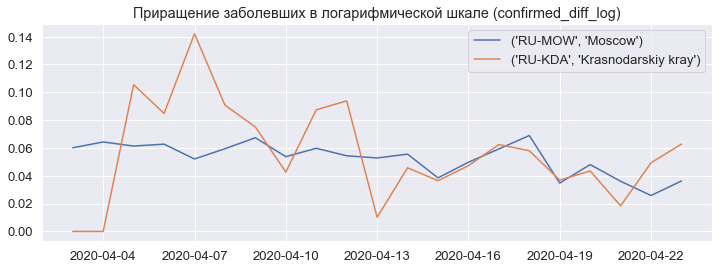

In [36]:
ind = (
    (df_all['date'] >= '2020-04-03') 
    & (df_all['date'] <= '2020-04-23') 
    & (df_all['shift'] == 1)
)
plt.figure(figsize=(12, 4))
for iso3 in ['RU-MOW', 'RU-KDA']:
    plt.plot(df_all[ind & (df_all['iso3'] == iso3)].date, 
             df_all[ind & (df_all['iso3'] == iso3)].confirmed_diff_log, label=(iso3, iso32country[iso3]))
plt.legend()
plt.title('Приращение заболевших в логарифмической шкале (confirmed_diff_log)')
plt.show()

## Вычисляем статистические факторы по историческим данным

**Временные окна**: 1, 2, 3, 5, 7, 10, 14 дней

**Сдвиги**: 1-7 дней

**Статистики**: среднее, медиана


Например, на конкретный день X считаем фактор - "среднее приращение заболевших при прогнозе на 2 дня вперед для окна в 3 дня":

```
день (X-4), прогноз на 2 дня вперед знаем, пусть он равен A.
день (X-3), прогноз на 2 дня вперед знаем, пусть он равен B.
день (X-2), прогноз на 2 дня вперед знаем, пусть он равен C.
день (X-1), прогноз на 2 дня вперед НЕ знаем, т.к. не хотим заглядывать в будущее.
день X - значение фактора равно (A + B + C) / 3
```

In [37]:
%%time
features = defaultdict(dict)
for cc in df_all['iso3'].unique():
    print(cc, end = ' ')
    for col in ['confirmed', 'deaths']:
        vv = df_all[(df_all['shift'] == 1) & (df_all['iso3'] == cc)][col].values
        vv = [np.nan if e == -1 else e for e in vv]
        for i in range(len(vv)):
            for shift in range(1, FORECAST_HORIZON):
                for ws in [1, 2, 3, 5, 7, 10, 14]:
                    real_ws = min(max(0, i - shift + 1), ws)
                    right = np.array(vv[max(0, i - real_ws + 1): max(0, i + 1)])
                    left = np.array(vv[max(0, i - shift - real_ws + 1): max(0, i - shift + 1)])
                    
                    f = np.mean(np.log10(right + 1) - np.log10(left + 1))
                    features[(cc, i)][f'f_{col}_diff_rel_ws{ws}_shift{shift}_mean'] = f
                    
                    f = np.median(np.log10(right + 1) - np.log10(left + 1))
                    features[(cc, i)][f'f_{col}_diff_rel_ws{ws}_shift{shift}_med'] = f                    
print()

AFG 

C:\Users\Alexandr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Alexandr\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ALB DZA AND AGO ATG AZE ARG AUS AUT BHS BHR BGD ARM BRB BEL BTN BOL BIH BRA BLZ BRN BGR BLR KHM CMR CAN CPV CAF LKA TCD CHL CHN TWN COL COG COD CRI HRV CUB CYP CZE BEN DNK DMA DOM ECU SLV GNQ ETH ERI EST FJI FIN FRA DJI GAB GEO GMB DEU GHA GRC GRD GTM GIN GUY HTI VAT HND HUN ISL IND IDN IRN IRQ IRL ISR ITA CIV JAM JPN KAZ JOR KEN KOR KWT KGZ LAO LBN LVA LBR LBY LIE LTU LUX MDG MYS MDV MLT MRT MUS MEX MCO MNG MDA MNE MAR MOZ OMN NAM NPL NLD NZL NIC NER NGA NOR PAK PAN PNG PRY PER PHL POL PRT TLS QAT ROU RUS RWA LCA VCT SMR SAU SEN SRB SYC SGP SVK VNM SVN SOM ZAF ZWE ESP SDN SUR SWZ SWE CHE SYR THA TGO TTO ARE TUN TUR UGA UKR MKD EGY GBR TZA USA BFA URY UZB VEN ZMB RU-ALT RU-AMU RU-ARK RU-AST RU-BEL RU-BRY RU-VLA RU-VGG RU-VLG RU-VOR RU-MOW RU-SPE UA-40 RU-YEV RU-ZAB RU-IVA RU-IRK RU-KGD RU-KLU RU-KAM RU-KEM RU-KIR RU-KOS RU-KDA RU-KYA RU-KGN RU-KRS RU-LEN RU-LIP RU-MAG RU-MOS RU-MUR RU-NEN RU-NIZ RU-NGR RU-NVS RU-OMS RU-ORE RU-ORL RU-PNZ RU-PER RU-PRI RU-PSK RU-AD RU-AL RU-BA RU-BU RU-D

In [38]:
dff = pd.DataFrame.from_dict(features, orient='index').reset_index()
dff.columns = ['iso3', 'date_ind'] + list(dff.columns[2:])

### Добавляем вычисленные факторы в датасет

In [39]:
df_all = df_all.merge(dff)

In [40]:
print(df_all.shape)

(609854, 180)


## Добавляем несколько факторов, известных про регионы

- population
- urban_pop_rate

In [41]:
# Избавляемся от Nan
countries_mean = countries.mean()
countries['urban_pop_rate'] = countries['urban_pop_rate'].fillna(countries_mean['urban_pop_rate'])
countries = countries.rename(columns={'iso_alpha3': 'iso3'})

df_all = df_all.merge(countries[['iso3', 'population', 'urban_pop_rate']])

In [42]:
df_all['is_ru'] = df_all['iso3'].apply(lambda x: x.startswith('RU-') or x .startswith('UA-')).astype(int)
print(f'Регионов России: {df_all[df_all.is_ru == 1].iso3.nunique()},'
      , f'   Стран: {df_all[df_all.is_ru == 0].iso3.nunique()}')

Регионов России: 85,    Стран: 169


## Обучение моделей и кросс-валидация

Фиксируем последнюю известную дату LAST_KNOWN_DATE (например, дедлайн для прогнозов на вторую неделю конкурса)

- тестовая выборка: даты `[LAST_KNOWN_DATE - 6, LAST_KNOWN_DATE]`
- тренировочная выборка: `[..., LAST_KNOWN_DATE - 7] (за исключением первых двух недель)`
- выборка для финального прогноза: `[LAST_KNOWN_DATE + 1, LAST_KNOWN_DATE + 7]`

In [43]:
LAST_KNOWN_DATE = '2020-04-19'
TEST_DAYS_CNT = 7
START_IND = 14

In [44]:
ind_train = (
    (df_all['date_ind'] >= START_IND) 
    & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(LAST_KNOWN_DATE)] - TEST_DAYS_CNT)
)
df_all['is_train'] = 0
df_all.loc[ind_train, 'is_train'] = 1

ind_test = (
    (df_all['date_ind'] >= START_IND) 
    & (df_all['date_ind'] + df_all['shift'] > date2ind[pd.Timestamp(LAST_KNOWN_DATE)] - TEST_DAYS_CNT)
    & (df_all['date_ind'] + df_all['shift'] <= date2ind[pd.Timestamp(LAST_KNOWN_DATE)])
)
df_all['is_test'] = 0
df_all.loc[ind_test, 'is_test'] = 1

ind_pred = (df_all['date_ind'] == date2ind[pd.Timestamp(LAST_KNOWN_DATE)])

df_all['is_pred'] = 0
df_all.loc[ind_pred, 'is_pred'] = 1

#### Проверим тренировочную выборку для Москвы

In [45]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all['is_train'] == 1)& (df_all['shift'] == 1)]\
    [['iso3', 'date', 'shift', 'date_pred', 'confirmed', 'confirmed_diff', 'confirmed_diff_log']].tail()

,iso3,date,shift,date_pred,confirmed,confirmed_diff,confirmed_diff_log
430297,RU-MOW,2020-04-07,1,2020-04-08,5181.0,660.0,0.052064
430304,RU-MOW,2020-04-08,1,2020-04-09,5841.0,857.0,0.059448
430311,RU-MOW,2020-04-09,1,2020-04-10,6698.0,1124.0,0.067363
430318,RU-MOW,2020-04-10,1,2020-04-11,7822.0,1030.0,0.053717
430325,RU-MOW,2020-04-11,1,2020-04-12,8852.0,1306.0,0.059760


#### Проверим тестовую выборку для Москвы

In [46]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all['is_test'] == 1) & (df_all['shift'] == 1)]\
    [['iso3', 'date', 'shift', 'date_pred', 'confirmed', 'confirmed_diff', 'confirmed_diff_log']]

,iso3,date,shift,date_pred,confirmed,confirmed_diff,confirmed_diff_log
430332,RU-MOW,2020-04-12,1,2020-04-13,10158.0,1355.0,0.054375
430339,RU-MOW,2020-04-13,1,2020-04-14,11513.0,1489.0,0.052817
430346,RU-MOW,2020-04-14,1,2020-04-15,13002.0,1774.0,0.055543
430353,RU-MOW,2020-04-15,1,2020-04-16,14776.0,1370.0,0.038506
430360,RU-MOW,2020-04-16,1,2020-04-17,16146.0,1959.0,0.049731
430367,RU-MOW,2020-04-17,1,2020-04-18,18105.0,2649.0,0.059300
430374,RU-MOW,2020-04-18,1,2020-04-19,20754.0,3570.0,0.068930


#### Проверим прогнозную выборку для Москвы

In [47]:
df_all[(df_all['iso3'] == 'RU-MOW') & (df_all['is_pred'] == 1)]\
    [['iso3', 'date', 'shift', 'date_pred', 'confirmed', 'confirmed_diff', 'confirmed_diff_log']]

,iso3,date,shift,date_pred,confirmed,confirmed_diff,confirmed_diff_log
430381,RU-MOW,2020-04-19,1,2020-04-20,24324.0,2026.0,0.034744
430382,RU-MOW,2020-04-19,2,2020-04-21,24324.0,5109.0,0.082796
430383,RU-MOW,2020-04-19,3,2020-04-22,24324.0,7657.0,0.118853
430384,RU-MOW,2020-04-19,4,2020-04-23,24324.0,9616.0,0.144672
430385,RU-MOW,2020-04-19,5,2020-04-24,24324.0,12573.0,0.180950
430386,RU-MOW,2020-04-19,6,2020-04-25,24324.0,15185.0,0.210654
430387,RU-MOW,2020-04-19,7,2020-04-26,24324.0,NaN,NaN


### Выбираем финальный набор факторов

In [48]:
f_names = ['shift', 'confirmed']
f_names += [e for e in df_all.columns if e.startswith('f_confirmed')]
f_names += ['population', 'urban_pop_rate', 'is_ru']
print(len(f_names))

89


### Подготавливаем датасеты

- для обучения
- для теста
- для прогноза
- для обучения на полных данных (для обучения финальных моделей, которыми будем делать инференс)

In [49]:
df_train = df_all[df_all['is_train'] == 1].copy()
df_test = df_all[df_all['is_test'] == 1].copy()
df_pred = df_all[df_all['is_pred'] == 1].copy()
df_train_all = df_all[(df_all['is_train'] == 1) | (df_all['is_test'] == 1)].copy()

print('Размер тренировочного датасета', len(df_train))
print('Размер тестового датасета', len(df_test))
print('Размер прогнозного датасета', len(df_pred))
print('Размер полного тренировочного датасета', len(df_train_all))

Размер тренировочного датасета 110236
Размер тестового датасета 12446
Размер прогнозного датасета 1778
Размер полного тренировочного датасета 122682


## Обучаем деревянную xgboost модель

**Деревья не умеют прогнозировать тренд**, но, благодаря тому что в качестве таргета используются приращения, эта проблема решается.

In [55]:
xgb_params = {
    'objective': 'reg:linear',
    'max_depth': 4, 
    'min_child_weight': 8, 
    'learning_rate': 0.077,
    'colsample_bylevel':  0.2,
    'silent': False,
    'seed': 0,
    'booster': 'gbtree',
    'alpha': 10,
    'beta': 1,
}

### Задаем веса обучающим примерам

Т.к. прогнозы на втором и третьем этапах оцениваются только по регионам России, странам можно давать меньший вес при обучении.

In [51]:
df_train['w'] = 1
df_train_all['w'] = 1

#### xgboost не умеет в null-ы, убедимся, что их нет

In [52]:
print(
    df_train[f_names + ['w', 'confirmed_diff_log']].isnull().sum().sum(),
    df_test[f_names + ['confirmed_diff_log']].isnull().sum().sum(),
    df_train_all[f_names + ['w', 'confirmed_diff_log']].isnull().sum().sum(),
    df_pred[f_names].isnull().sum().sum()
)

0 0 0 0


In [53]:
def xgb_mae(preds, dtrain):
    labels = dtrain.get_label()
    return('mae', np.mean(np.abs(labels - preds)))

def train_xgboost(df_train, df_test, df_train_all, fnames, target, xgb_params, num_rounds):
    dtrain = xgb.DMatrix(df_train[fnames], df_train[target], weight=df_train['w'])
    dtrain_all = xgb.DMatrix(df_train_all[fnames], df_train_all[target], weight=df_train_all['w'])
    dtest = xgb.DMatrix(df_test[fnames], df_test[target])
    dtest_ru = xgb.DMatrix(df_test[df_test['is_ru'] == 1][fnames], df_test[df_test['is_ru'] == 1][target])
    
    watchlist  = [(dtest, 'test'), (dtest_ru, 'test_ru'), (dtrain, 'train')]
    
    evals_result = {}
    print('train')
    xgb_model = xgb.train(
        xgb_params, dtrain, num_rounds, watchlist, feval=xgb_mae, evals_result=evals_result, verbose_eval=20
    )
    print()
    print('train_all')
    xgb_model_all = xgb.train(
        xgb_params, dtrain_all, num_rounds, watchlist, feval=xgb_mae, evals_result=evals_result, verbose_eval=20
    )
    print()
    return xgb_model, xgb_model_all

#### Обучаем бустинг на деревьях

In [56]:
target = 'confirmed_diff_log'
num_rounds = 120
fnames = f_names.copy()
xgb_model, xgb_model_all = train_xgboost(
    df_train, df_test, df_train_all, fnames, target, xgb_params, num_rounds
)

train
[0]	test-rmse:0.363288	test_ru-rmse:0.291629	train-rmse:0.411452	test-mae:0.338977	test_ru-mae:0.252178	train-mae:0.386288
[20]	test-rmse:0.160404	test_ru-rmse:0.194495	train-rmse:0.217343	test-mae:0.131035	test_ru-mae:0.1437	train-mae:0.168506
[40]	test-rmse:0.138708	test_ru-rmse:0.191033	train-rmse:0.199688	test-mae:0.093958	test_ru-mae:0.129727	train-mae:0.125922
[60]	test-rmse:0.135746	test_ru-rmse:0.191212	train-rmse:0.19626	test-mae:0.085412	test_ru-mae:0.127543	train-mae:0.115935
[80]	test-rmse:0.134275	test_ru-rmse:0.188704	train-rmse:0.194577	test-mae:0.083018	test_ru-mae:0.125463	train-mae:0.112706
[100]	test-rmse:0.133491	test_ru-rmse:0.187922	train-rmse:0.193559	test-mae:0.08201	test_ru-mae:0.12503	train-mae:0.11154
[119]	test-rmse:0.132364	test_ru-rmse:0.18648	train-rmse:0.192614	test-mae:0.080777	test_ru-mae:0.124211	train-mae:0.110643

train_all
[0]	test-rmse:0.362426	test_ru-rmse:0.291573	train-rmse:0.411435	test-mae:0.338282	test_ru-mae:0.252095	train-mae:0.38628

### Посмотрим на важность факторов в деревянной модели

- логично, что самым важным фактором является сдвиг - т.е. то, насколько далеко вперед хочется сделать прогноз

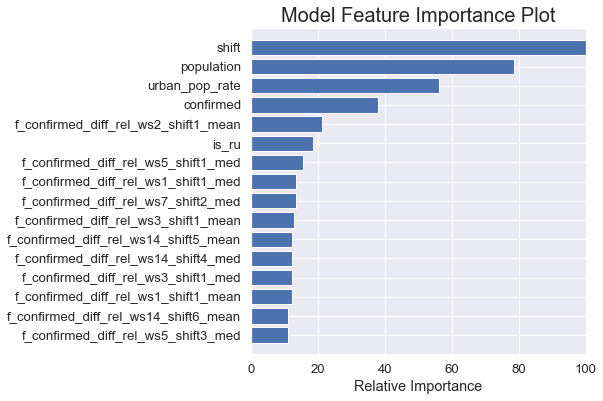

In [57]:
from feature_importance import get_feature_importance, draw_feature_importance
draw_feature_importance(
    get_feature_importance(fnames, xgb_model),
    topn=16
)

## Получим прогнозы на тестовой и прогнозной выборках

Для тестовой выборки используем модель, обученную на тренировочной выборке

Для прогнозной выборки используем финальную модель

In [58]:
def inference_xgboost(df_pred, fnames, model):
    dpred = xgb.DMatrix(df_pred[fnames])
    preds = model.predict(dpred)
    return preds

In [75]:
test_pred = inference_xgboost(df_test, fnames, xgb_model)
final_pred = inference_xgboost(df_pred, fnames, xgb_model)

df_test['pred_final'] = test_pred
df_pred['pred_final'] = final_pred

### Перейдем в исходную шкалу и посмотрим на прогнозы

In [76]:
df_test['pred_real'] = 10**(df_test['pred_final'] + np.log10(df_test['confirmed'] + 1)) - 1
df_pred['pred_real'] = 10**(df_pred['pred_final'] + np.log10(df_pred['confirmed'] + 1)) - 1

In [190]:
def draw_forecast(iso3_list, df_all, df_pred, pred_columns):
    plt.figure(figsize=(16, 10))
    for i, iso3 in enumerate(iso3_list):
        plt.subplot(2, 2, i + 1)
        baz_tr = df_all[(df_all['iso3'] == iso3) & (df_all['shift'] == 1) & (df_all['confirmed'] > 0)]
        plt.plot(baz_tr['date'], baz_tr['confirmed'], label='истинное значение', marker='o')
        baz_pr = df_pred[(df_pred['iso3'] == iso3)]
        for col, col_label in pred_columns.items():
            plt.plot(baz_pr['date_pred'], baz_pr[col], label=col_label, marker='o')

        plt.xlim(['2020-04-01', None])
        plt.xticks(rotation=20)
        plt.legend()
        plt.title((iso3, iso32country[iso3]))
    plt.tight_layout()
    plt.show()

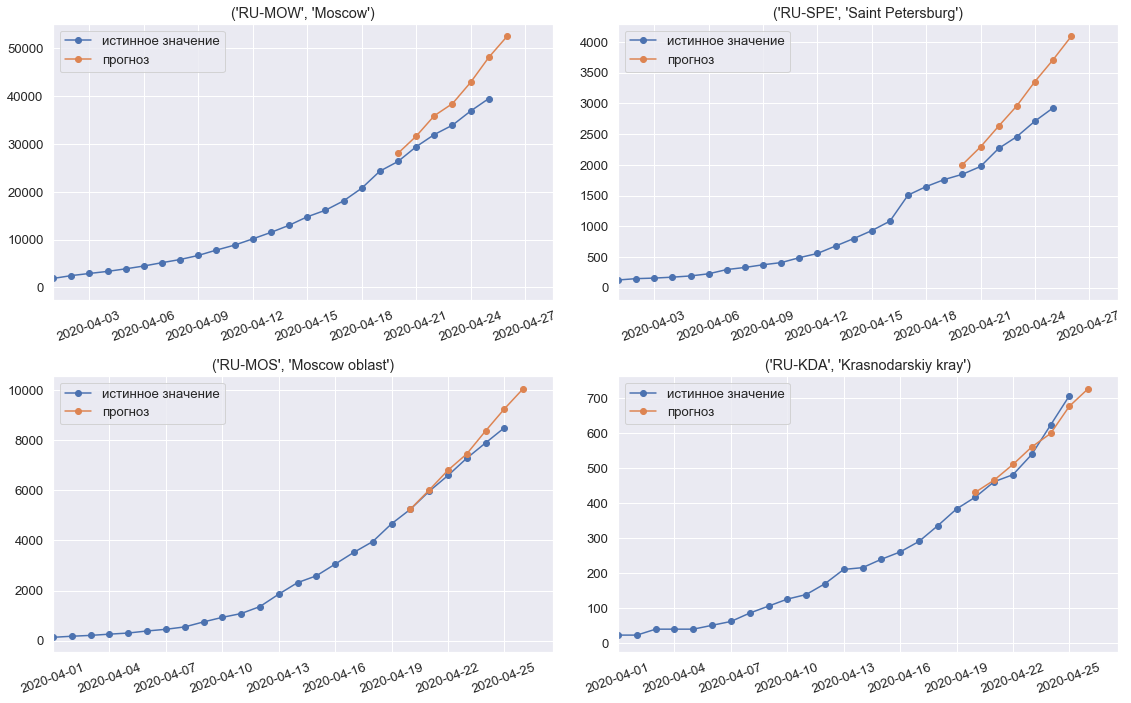

In [191]:
draw_forecast(['RU-MOW', 'RU-SPE', 'RU-MOS', 'RU-KDA'], df_all, df_pred, {'pred_real': 'прогноз'})

### Сохраним прогноз

In [80]:
def save_predictions(df_pred, filename, pred_col='pred_real'):
    data_ans = pd.read_csv(os.path.join('data', 'sample_submission_stage2.csv'))
    data_ans = data_ans.rename(columns={'region': 'iso3'})

    final_df = df_pred[['iso3', 'date_pred', 'shift', pred_col]].copy()
    final_df['date'] = final_df['date_pred'].astype(str)
    final_df

    data_ans = data_ans.merge(final_df, how='left')

    data_ans.loc[~data_ans[pred_col].isnull(), 'prediction_confirmed'] = (
        data_ans.loc[~data_ans[pred_col].isnull(), pred_col]
    ).apply(lambda x: int(x + 0.5))

    data_ans['prediction_confirmed'] = data_ans['prediction_confirmed'].astype(int)
    data_ans['country'] = data_ans['iso3']

    baz = data_ans[['date', 'country', 'prediction_confirmed', 'prediction_deaths']].copy()
    baz.to_csv(os.path.join('submissions', filename), encoding='utf-8', index=False)    

In [64]:
save_predictions(df_pred, 'baseline_submission.csv')

## Попробуем улучшить прогнозы, используя данные только за последнюю неделю 

Обучив модель на тренировочной выборке и сделав инференс на тестовой, мы получили честные прогнозы на тесте.

Для каждого региона и сдвига можно подобрать линейное преобразование прогнозов, максимизирующих качечство на тесте - т.е. качество на последней неделе наблюдений.

Осторожно: несмотря на настройку всего одного коэффициента, есть риск переобучиться для каждого региона под тест и в итоге получить худшее качество по сравнению с базовой моделью :)

In [182]:
def mae(y_true, y_pred, weights=1):
    return np.sum(weights * np.abs((y_pred - y_true))) / np.sum(weights * np.ones(len(y_true)))

df_pred['pred_final_v2'] = df_pred['pred_final']

for iso3 in df_test['iso3'].unique():
    ind = (df_test['iso3'] == iso3)
    true_values_ind = df_test[ind]['confirmed_diff_log'].values

    best_alpha = 1.0
    best_score = 1e9
    for alpha in np.linspace(0.1, 1.0, 10):
        pred_values_ind = (alpha * df_test.loc[ind, 'pred_final']).values
        score = mae(true_values_ind, pred_values_ind)
        if score < best_score:
            best_alpha = alpha
            best_score = score
    if iso3.startswith('RU-') and best_alpha != 1:
        print(iso3, shift, best_alpha)

    ind = (df_pred['iso3'] == iso3)
    df_pred.loc[ind, 'pred_final_v2'] = best_alpha * df_pred.loc[ind, 'pred_final']

RU-ALT 6 0.8
RU-AMU 6 0.6
RU-ARK 6 0.5
RU-BRY 6 0.8
RU-VGG 6 0.8
RU-VLG 6 0.7000000000000001
RU-YEV 6 0.6
RU-IVA 6 0.9
RU-KGD 6 0.6
RU-KEM 6 0.8
RU-KDA 6 0.9
RU-LIP 6 0.8
RU-NEN 6 0.1
RU-OMS 6 0.6
RU-PNZ 6 0.8
RU-PRI 6 0.9
RU-AL 6 0.1
RU-BU 6 0.9
RU-KL 6 0.7000000000000001
RU-TY 6 0.8
RU-SAK 6 0.1
RU-KHM 6 0.9
RU-CHE 6 0.8
RU-YAN 6 0.7000000000000001


In [183]:
df_pred['pred_real_v2'] = 10**(df_pred['pred_final_v2'] + np.log10(df_pred['confirmed'] + 1)) - 1

#### Посмотрим, как изменились прогнозы

По Москве коэффициент получился равным 1.0 - поэтому оранжевая и зеленая линии наложились

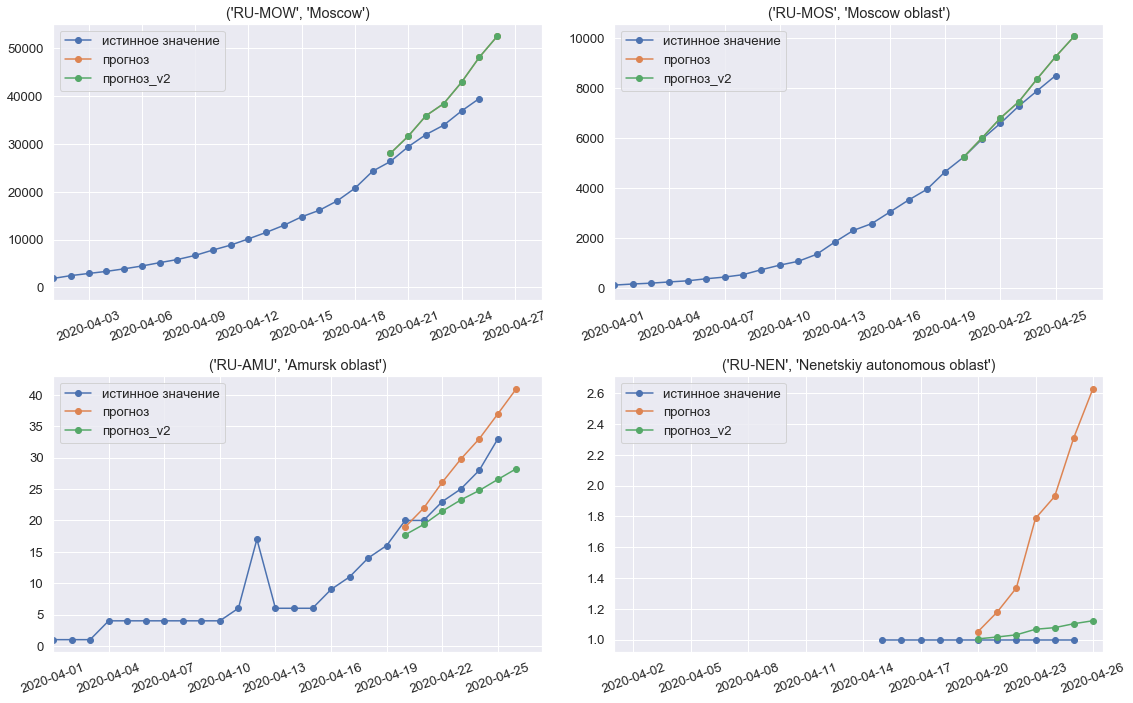

In [195]:
draw_forecast(['RU-MOW', 'RU-MOS', 'RU-AMU', 'RU-NEN'], df_all, df_pred, 
              {'pred_real': 'прогноз', 'pred_real_v2': 'прогноз_v2'})

In [189]:
save_predictions(df_pred, 'baseline_submission_v2.csv', pred_col='pred_real_v2')